## Importing data

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/identifying-disease-in-tea-leafs
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/Anthracnose
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/healthy
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/bird eye spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/brown blight
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/red leaf spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/gray light
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/algal leaf


In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3
from keras.applications import ResNet50V2

2025-08-22 17:21:51.902896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755883312.264647      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755883312.364335      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Image sample

In [5]:
image = cv.imread("/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_100.jpg")
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

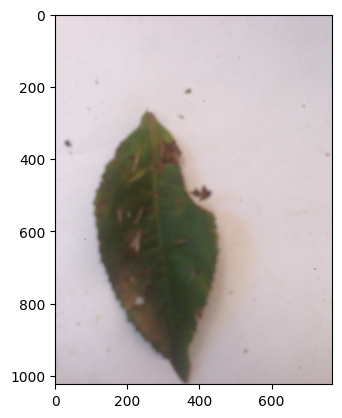

(1024, 768, 3)


In [6]:
plt.imshow(image_rgb)
plt.show()
print(image.shape)

## Data preprocessing 

In [7]:
path = "/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset"

train,test = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    seed=42,
    batch_size=32,
    image_size=(500, 500),
)

train=train.cache().prefetch(1).shuffle(100)
test=test.cache().prefetch(1)

Found 885 files belonging to 8 classes.
Using 708 files for training.
Using 177 files for validation.


I0000 00:00:1755883379.767099      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755883379.767889      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# **01. EfficientNetV2B3**

In [69]:
eff_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(500,500,3))
eff_model.trainable = False

## Output layers configuration

In [70]:
# EfficientNet Base model output
eff_out = eff_model.output

# Configure our custom output layer
x = Flatten()(eff_out)
x = Dense(512, activation='relu')(x)
x = Dense(8, activation='softmax')(x)

# Create final model
model01 = tf.keras.Model(inputs=eff_model.input, outputs=x)

## Compiling and training

In [71]:
model01.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
es=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-10,
)

In [73]:
model01.fit(
    train,
    epochs=30,
    validation_data=test,
    callbacks=[es, lr]
)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9447 - loss: 1.3007 - val_accuracy: 0.7458 - val_loss: 11.7693 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - accuracy: 0.9011 - loss: 3.1565 - val_accuracy: 0.7684 - val_loss: 8.8223 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.9165 - loss: 2.6045 - val_accuracy: 0.8814 - val_loss: 5.3524 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.9298 - loss: 2.2654 - val_accuracy: 0.7345 - val_loss: 18.6398 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.9508 - loss: 3.0217 - val_accuracy: 0.7740 - val_loss: 13.3236 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9514 - loss: 1.8185 - val_accuracy: 0.7910 - val_loss: 15.8011 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.9497 - loss: 2.8101

## Confusion matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step 


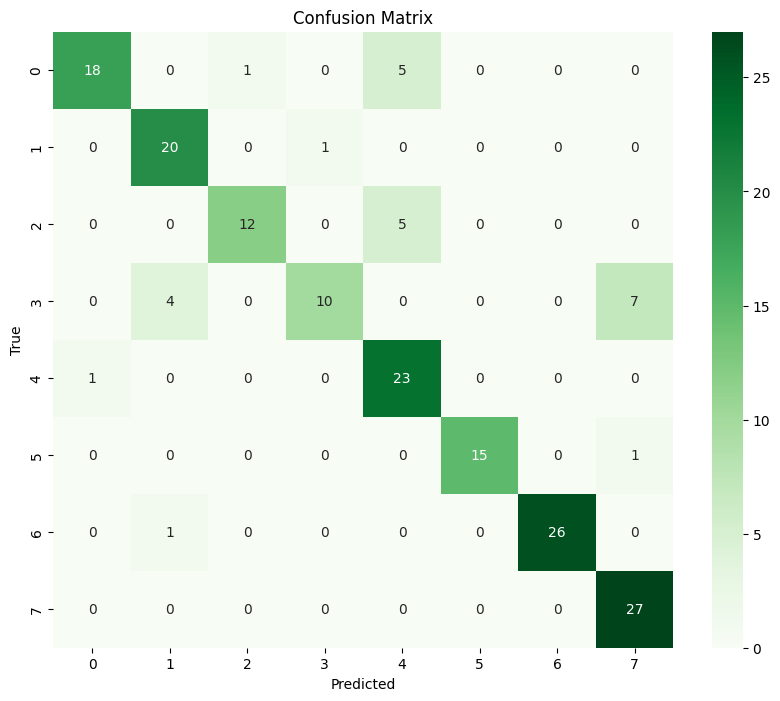

In [12]:
eff_pred = model01.predict(test)
eff_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for images, labels in test:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)


cm = confusion_matrix(y_true, eff_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

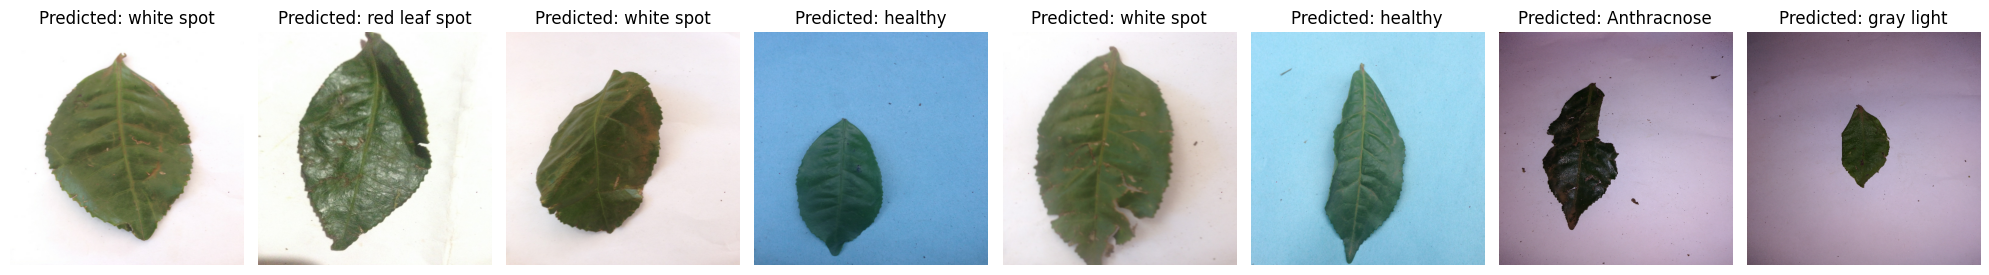

In [43]:
class_names  = ["Anthracnose","algal leaf","bird eye spot","brown blight","gray light","healthy","red leaf spot","white spot"]

# Plotting first 8 images in test set along with respective model predictions 
fig ,axs = plt.subplots(1,8, figsize=(20,20))
for images, labels in test.take(1):
    for idx in range(8):

        
        image = images[idx].numpy().astype(np.uint8)
        predicted_class = eff_pred_classes[idx]

        axs[idx].imshow(image)
        axs[idx].set_title(f"Predicted: {class_names[predicted_class]}")
        axs[idx].axis("off")
        
    
plt.tight_layout()
plt.show()

## F1- Score

In [44]:
score = f1_score(y_true, y_pred_classes, average='micro')
print(score)

0.8531073446327684


## Achieved F1 Score is: 0.853

# **02. ResNet50V2**

In [8]:
res_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(500,500,3))
res_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# ResNet base model
res_out = res_model.output

# Ouput layer
x2 = Flatten()(res_out)
x2 = Dense(512, activation='relu')(x2)
x2 = Dense(8, activation='softmax')(x2)

# Final ResNet model
model02 = tf.keras.Model(inputs=res_model.input, outputs=x2)

In [10]:
model02.compile(
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ['accuracy']
)

In [13]:
model02.fit(
    train,
    epochs = 30,
    validation_data = test,
    callbacks = [es, lr]
)

Epoch 1/30


I0000 00:00:1755883470.256941     115 service.cc:148] XLA service 0x7f4670044980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755883470.258315     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755883470.258335     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755883471.608138     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755883490.569550     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.1448 - loss: 32586.2773 - val_accuracy: 0.3672 - val_loss: 5535.2993 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.4199 - loss: 3624.1809 - val_accuracy: 0.4746 - val_loss: 1587.7954 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.5899 - loss: 659.5354 - val_accuracy: 0.5819 - val_loss: 531.3323 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.5924 - loss: 669.8198 - val_accuracy: 0.6271 - val_loss: 361.3028 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.6876 - loss: 313.8501 - val_accuracy: 0.4915 - val_loss: 781.9153 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.6574 - loss: 432.8685 - val_accuracy: 0.6102 - val_loss: 610.1380 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - accuracy: 0.670

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step


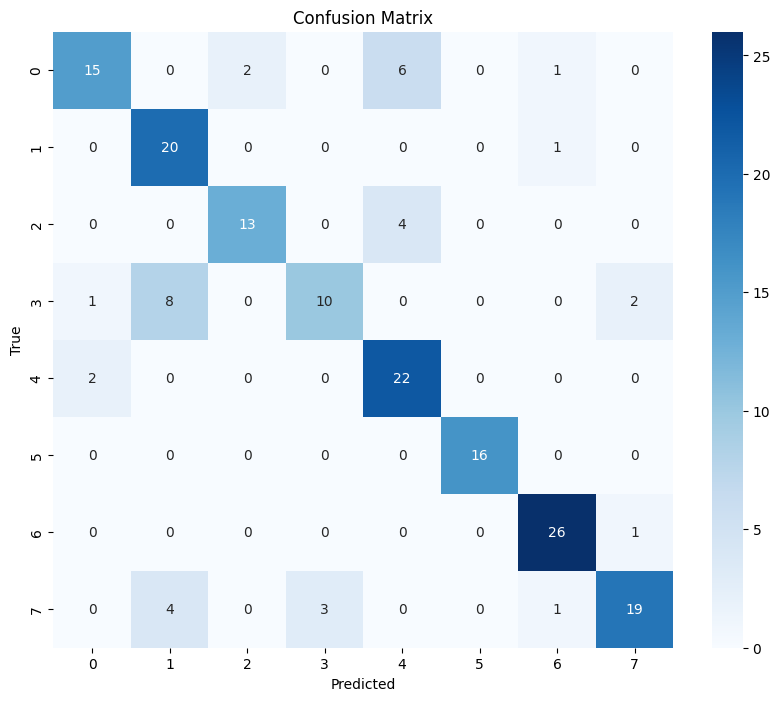

In [17]:
res_pred = model02.predict(test)
res_pred_classes = np.argmax(res_pred, axis=1)


y_true = []
for images, labels in test:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)


cm = confusion_matrix(y_true, res_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
score2 = f1_score(y_true, res_pred_classes, average='micro')
print(score2)

0.7966101694915254
